# Introduction

Nothing ruins the thrill of buying a brand new car more quickly than seeing your new insurance bill. The sting’s even more painful when you know you’re a good driver. It doesn’t seem fair that you have to pay so much if you’ve been cautious on the road for years.

Porto Seguro, one of Brazil’s largest auto and homeowner insurance companies, completely agrees. Inaccuracies in car insurance company’s claim predictions raise the cost of insurance for good drivers and reduce the price for bad ones.

In this competition, you’re challenged to build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year. While Porto Seguro has used machine learning for the past 20 years, they’re looking to Kaggle’s machine learning community to explore new, more powerful methods. A more accurate prediction will allow them to further tailor their prices, and hopefully make auto insurance coverage more accessible to more drivers.

# Data Description

In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. Values of -1 indicate that the feature was missing from the observation. The target columns signifies whether or not a claim was filed for that policy holder.

# Loading Packages

In [55]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
sns.set_style("darkgrid")

In [56]:

train = pd.read_csv(r"C:\Users\Ravindra\Desktop\Diploma Thesis\porto-seguro-safe-driver-prediction\train.csv") 
print(train.shape)
test = pd.read_csv(r"C:\Users\Ravindra\Desktop\Diploma Thesis\porto-seguro-safe-driver-prediction\test.csv") 
print(test.shape)

(595212, 59)
(892816, 58)


In [57]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


The test dataset doesn't have the column target. I will be predicting whethere a claim will be filed (target = 1) or not (target = 0).

# About Missing Data

From data description, values of -1 indicate that the feature was missing from the observation. Let's check missing data.

Top 5 features with most missing data in training dataset

In [58]:
train = train.replace(-1, np.nan)
train_missing = train.isnull().sum().sort_values(ascending=False)
train_missing = pd.DataFrame(train_missing).reset_index()
train_missing.columns = ['Feature', 'Number of Data Records Missing']
train_missing.head()

,Feature,Number of Data Records Missing
0,ps_car_03_cat,411231
1,ps_car_05_cat,266551
2,ps_reg_03,107772
3,ps_car_14,42620
4,ps_car_07_cat,11489


Visualize the percentage of data missing

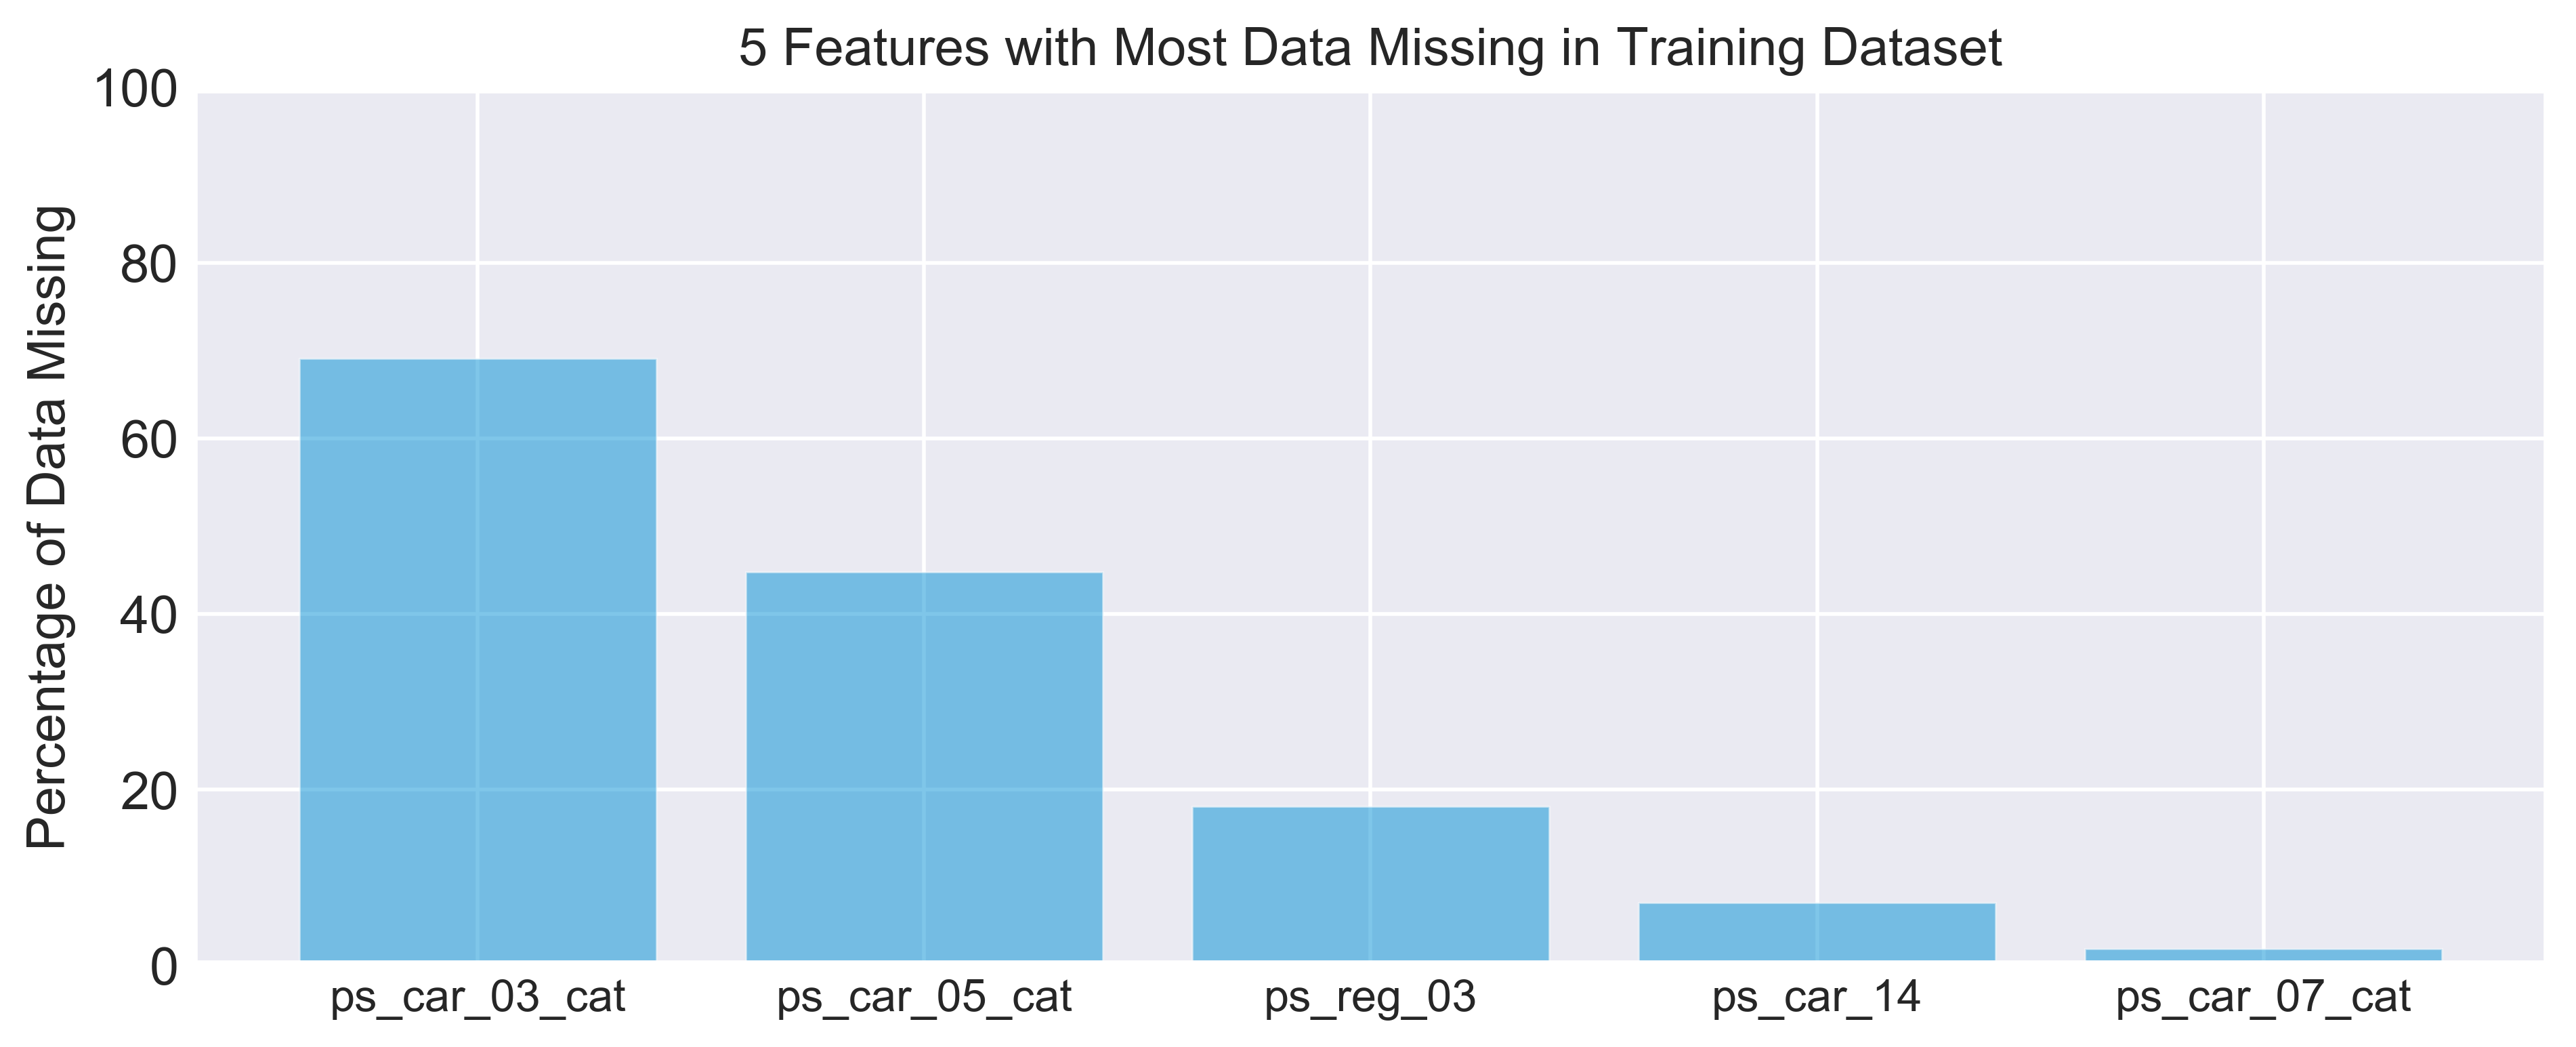

In [59]:
train_missingpercent = 100 * (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

plt.figure(figsize = (10, 4), dpi = 400)
plt.bar(np.arange(5), train_missingpercent[:5], align='center', alpha=0.5)
plt.xticks(np.arange(5), train_missingpercent.index[:5], fontsize=12)
plt.ylim(0, 100)
plt.ylabel('Percentage of Data Missing', fontsize = 14)
plt.title('5 Features with Most Data Missing in Training Dataset', fontsize = 14) 
plt.savefig('five_features.jpg')
plt.show()

# Drop Redundant Features & Replace Missing Data

Features 'ps_car_03_cat' and 'ps_car_05_cat' have more than 40% data missing, drop them.
Analyze the correlations of all remaining features, drop redundant features
Replace missing data in remaining features

In [60]:
# drop features 'ps_car_03_cat' and 'ps_car_05_cat'
train = train.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)
test = test.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)

visualize the correlation between remaining features

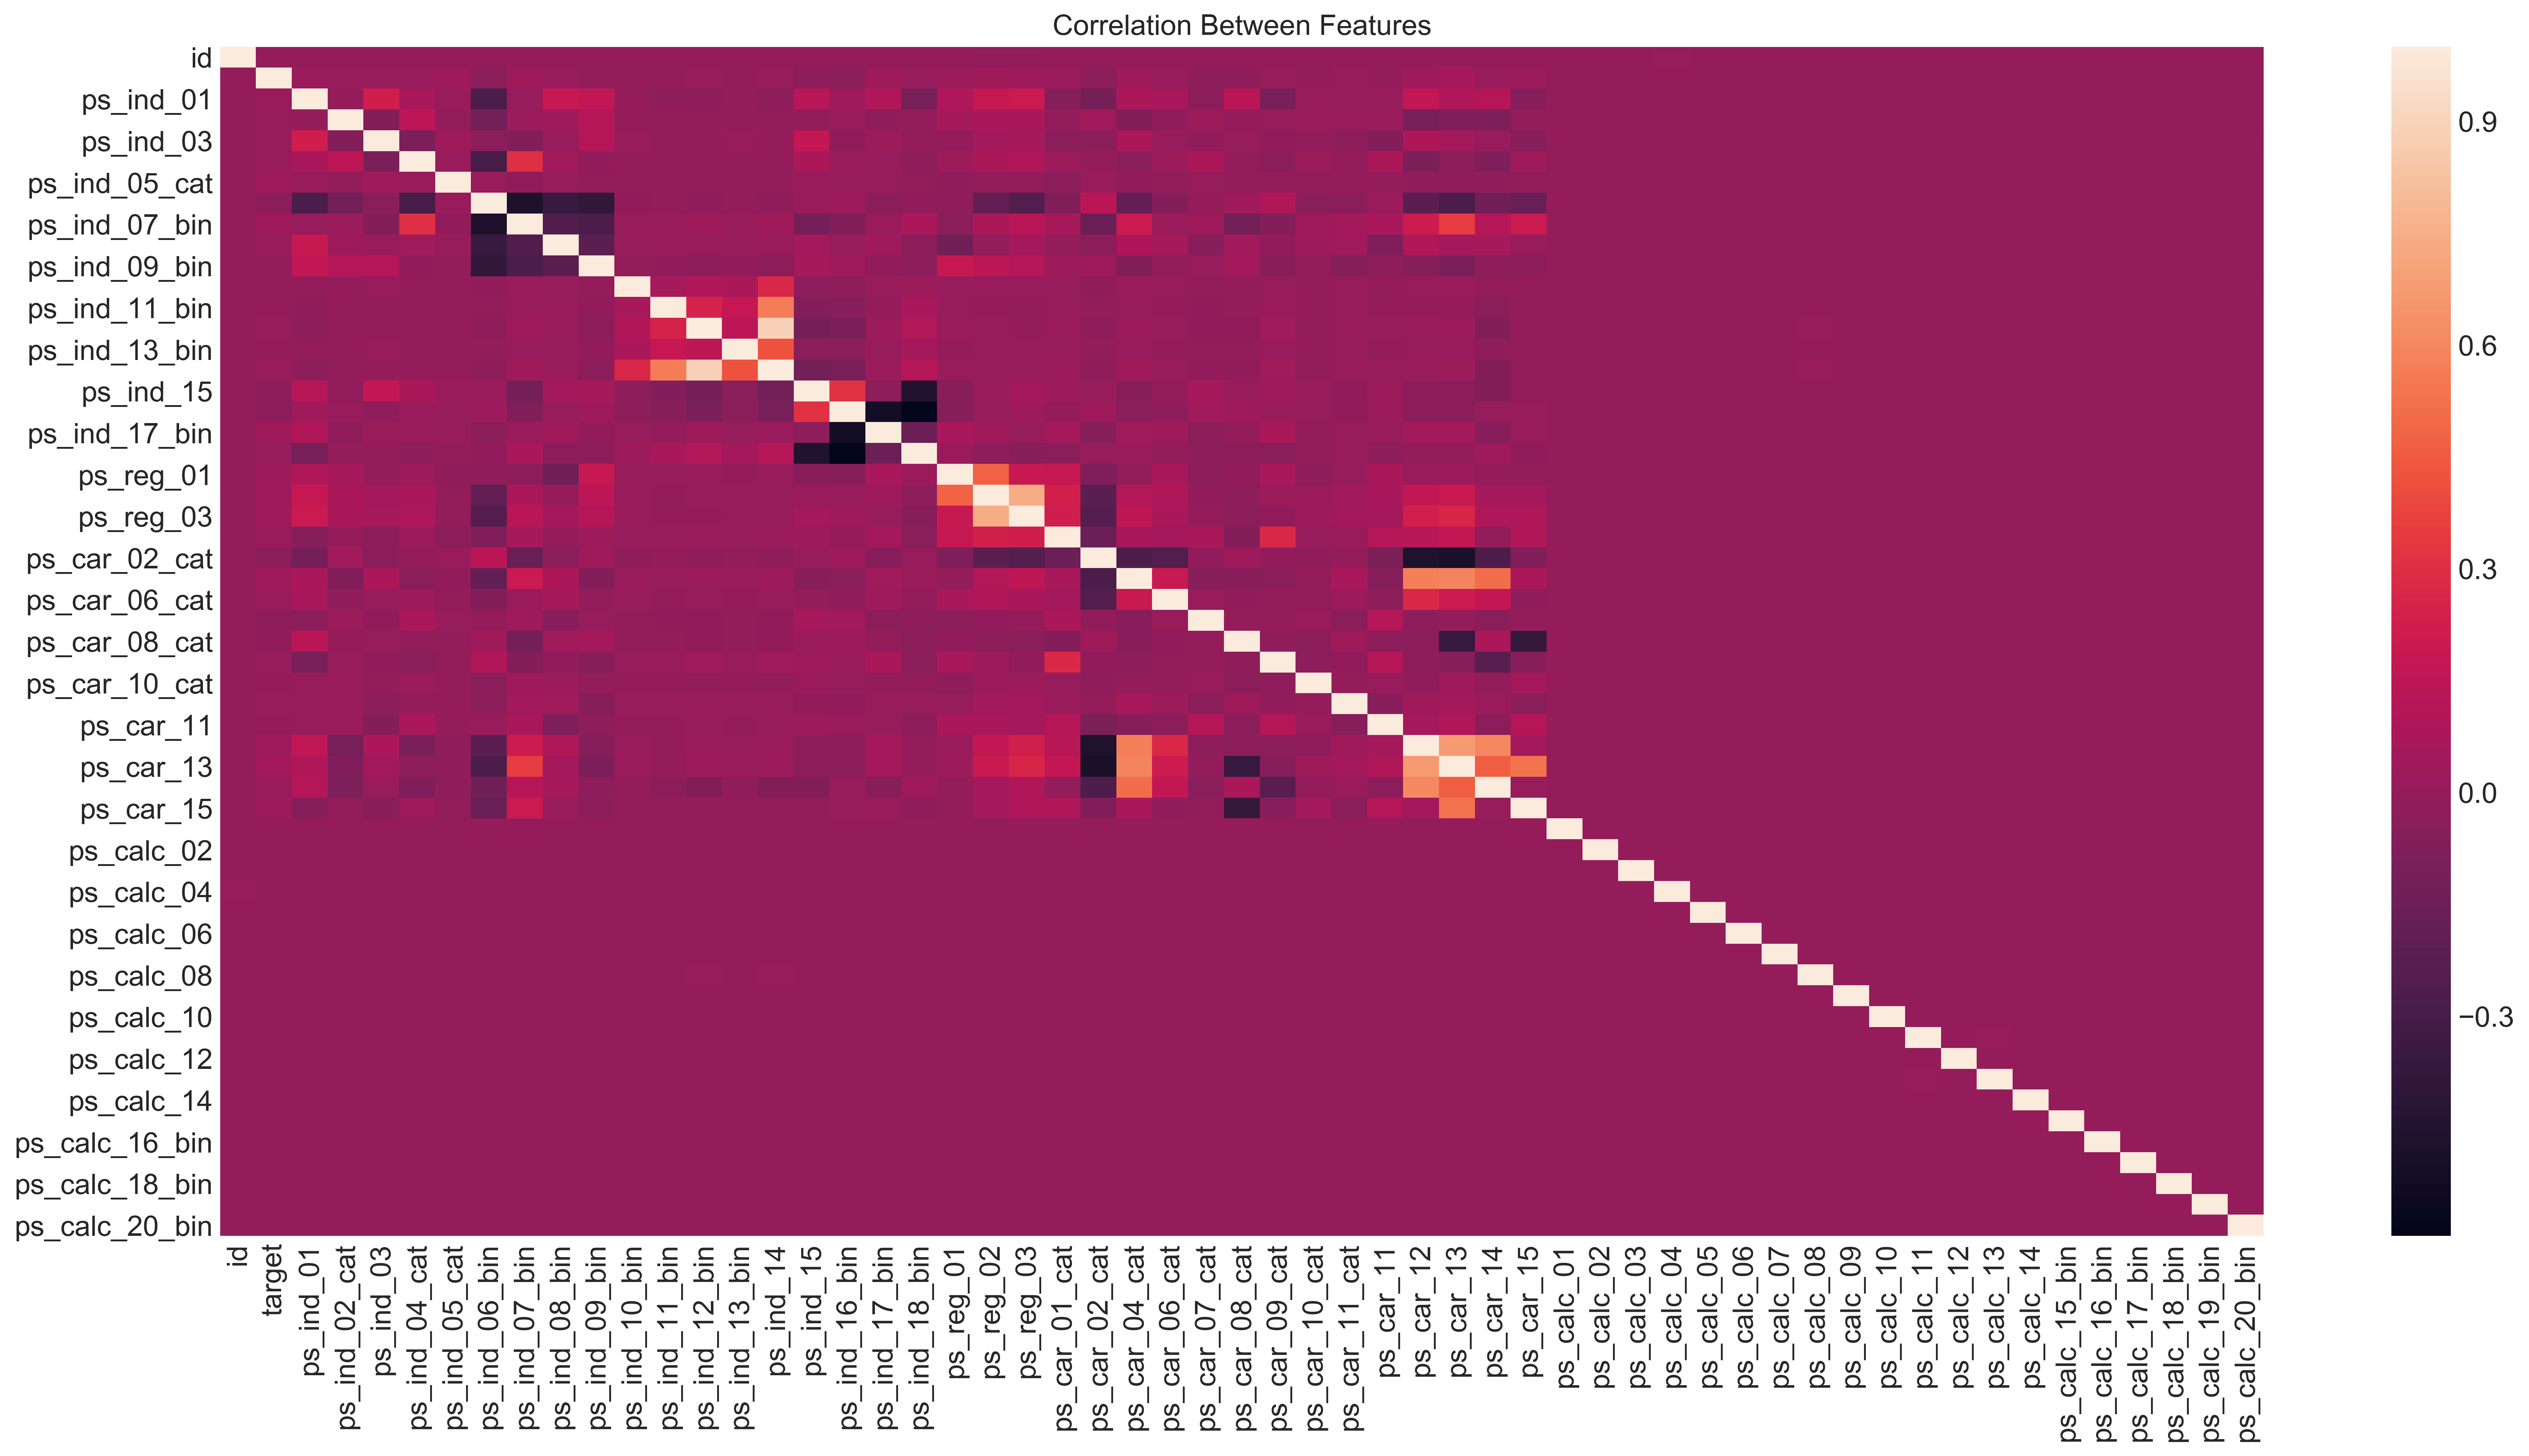

In [61]:
corr = train.corr()

plt.figure(figsize = (20,10), dpi= 400)
sns.heatmap(corr)
plt.title("Correlation Between Features", fontsize = 14)
plt.xticks(rotation = 'vertical')
plt.savefig('correlation.jpg')
plt.show()

Features with calc in their names show little correlation with any other features in the training dataset. For dimensionality reduction, we should drop these features also.

In [62]:
# drop features with '_calc_' in feature names
feature_calc = list(train.columns[train.columns.str.contains('_calc_')])

train = train.drop(feature_calc, axis = 1)
test = test.drop(feature_calc, axis = 1)

print(train.shape)
print(test.shape)

(595212, 37)
(892816, 36)


Now replace the missing data in the remaining features:

For binary features (bin) and categorical features (cat), replace missing data with the most frequent value of the feature

For other features (continuous or ordinal), replace missing data with mean value of the feature

In [63]:
# replace missing data in the remaining features
feature_bin = [f for f in train.columns if f.endswith('bin')] 
feature_cat = [f for f in train.columns if f.endswith('cat')] 
feature_els = [f for f in train.columns if (f not in feature_bin) & (f not in feature_cat) & (f not in ['id', 'target'])]

for f in (feature_bin + feature_cat):
    train[f].fillna(value=train[f].mode()[0], inplace=True)
    test[f].fillna(value=test[f].mode()[0], inplace=True)
    
for f in feature_els:
    train[f].fillna(value=train[f].mean(), inplace=True)
    test[f].fillna(value=test[f].mean(), inplace=True)

Now let's look at these features' data distribution:

In [64]:
# Visualize binary features data and categorical features data (for styling, plot only features with 2 unique values)
plt.figure(figsize=(20, 20), dpi = 400)
count = 0

for f in (feature_bin + feature_cat):
    if  train[f].nunique() <= 2:
        ax = plt.subplot(4, 4, count+1)
        sns.countplot(train[f])
        plt.xlabel(f, fontsize = 14)
        plt.ylabel("Count", fontsize = 12)
        plt.ylim(0, 600000)
        count += 1
        
plt.savefig('distribution.jpg')
plt.show()

# Data Preparation

Before applying machine learning algorithms, I should conduct feature standardization (z-score normalization).

In [65]:
# standardization of non categorical features
feature_non_cat = [f for f in train.columns if (f.endswith('cat') != True) & (f not in ['id', 'target'])]
scaler = StandardScaler()

X_train = train.drop(['target', 'id'], axis=1)
y_train = train['target']
X_valid = test.drop('id', axis=1)

X_train.loc[:, feature_non_cat] = scaler.fit_transform(X_train[feature_non_cat])
X_valid.loc[:, feature_non_cat] = scaler.transform(X_valid[feature_non_cat])

C:\Users\Ravindra\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ravindra\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Ravindra\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Now I will covert categorical features to dummy variables (one-hot encoding). One thing to note is that feature 'ps_car_11_cat' has 104 unique values.

In [66]:
print(train['ps_car_11_cat'].unique())

[ 12  19  60 104  82  99  30  68  20  36 101 103  41  59  43  64  29  95
  24   5  28  87  66  10  26  54  32  38  83  89  49  93   1  22  85  78
  31  34   7   8   3  46  27  25  61  16  69  40  76  39  88  42  75  91
  23   2  71  90  80  44  92  72  96  86  62  33  67  73  77  18  21  74
  37  48  70  13  15 102  53  65 100  51  79  52  63  94   6  57  35  98
  56  97  55  84  50   4  58   9  17  11  45  14  81  47]


Because of the amount of categorical feature 'ps_car_11_cat' and other features have, the next step (coverting to dummy variables) will use about 2.2 GB memory and produce sparse matrix. Although executing the next cell is not very time-consuming, sometimes I run out of memory if I have many other applications running on my computer.

In [67]:
# covert categorical features to dummy variables
train_num = train.shape[0]

dataset = pd.concat([X_train, X_valid], axis=0)   
dataset = pd.get_dummies(columns=feature_cat, data=dataset)

X_train = dataset[:train_num]
X_valid = dataset[train_num:]
print(X_train.shape)
print(X_valid.shape)

(595212, 201)
(892816, 201)


# Feature Selection (Random Forest Classifier)

Wow, now we have dataframes with 201 columns (features), let's use random forest classifier to select 20 most important features contributing to a claim to be filed (target = 1).

In [68]:
# split training dataset to random training and testing dataset for validation later
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size = 0.7)

C:\Users\Ravindra\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [69]:
# train the model with 50 trees, 4 parallel processes, and 10 minimum samples to split a node 
num_trees = 50
rf = RandomForestClassifier(n_estimators=num_trees, n_jobs=4, min_samples_split=10, verbose=2, oob_score = True)
rf.fit(X=X_train, y=y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 50building tree 2 of 50building tree 3 of 50

building tree 4 of 50

building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   52.1s


building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.3min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
            oob_score=True, random_state=None, verbose=2, warm_start=False)

In [70]:
# generate predictions on test datasets (which is a random subset split from the training set)
rf_predictions = rf.predict_proba(X_test)[:, 1]

# get AUC score (produce probabilistic predictions)
print(roc_auc_score(y_test, rf_predictions))

# get accuracy score (predict the class)
rf_predictions_class = rf.predict(X_test)
print(accuracy_score(y_test, rf_predictions_class, normalize=True))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.8s finished


0.5908204575547282


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    1.7s


0.9641585089939742


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    2.6s finished


In [71]:
# select 20 most important features 
# print out and store the 20 features' names and their importances to a dataframe 'df_feature_select20'
feature_names = list(X_test.columns.values)
feature_importances = list(rf.feature_importances_)
feature_list = []

for i in range(0,len(feature_names)):
    feature_list.append((feature_names[i], feature_importances[i]))
    
df_feature_select20 = pd.DataFrame(sorted(feature_list, reverse=True, key=lambda x: x[1])[:20])
df_feature_select20.columns = ['feature_select', 'feature_importance']
print(df_feature_select20)

        feature_select  feature_importance
0            ps_car_13            0.096632
1            ps_reg_03            0.092313
2            ps_car_14            0.057626
3            ps_ind_03            0.051522
4            ps_ind_15            0.050959
5            ps_reg_02            0.048221
6            ps_car_15            0.037705
7            ps_ind_01            0.036697
8            ps_reg_01            0.036370
9            ps_car_12            0.027562
10           ps_car_11            0.012717
11   ps_ind_04_cat_0.0            0.008678
12   ps_car_09_cat_2.0            0.008638
13   ps_ind_02_cat_1.0            0.008468
14  ps_car_01_cat_11.0            0.008439
15   ps_ind_04_cat_1.0            0.008250
16   ps_ind_02_cat_2.0            0.007941
17   ps_car_01_cat_7.0            0.007599
18   ps_car_09_cat_0.0            0.007420
19       ps_ind_16_bin            0.007260


In [72]:
# slice datasets to contain information on only these 20 features
X_train_select20 = X_train[df_feature_select20['feature_select']]
X_valid_select20 = X_valid[df_feature_select20['feature_select']]
X_test_select20 = X_test[df_feature_select20['feature_select']]

# Train A Model (Logistic Regression)

Let's train a model learning from data on data of these selected featues.

In [73]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

# calculate regression score to test over fitting
print(lr.score(X_train, y_train) , lr.score(X_test, y_test))

C:\Users\Ravindra\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9632951556229719 0.9641529087610045


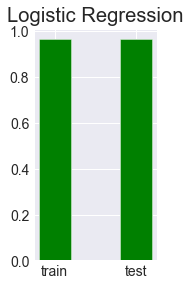

In [74]:
import matplotlib.pyplot as plt
 
# creating the dataset
data = {'train':lr.score(X_train, y_train), 'test':lr.score(X_test, y_test)}
courses = list(data.keys())*10
values = list(data.values())*10
  
fig = plt.figure(figsize = (2, 4))
 
# creating the bar plot
plt.bar(courses, values, color ='green',
        width = 0.4)

plt.title("Logistic Regression")
plt.show()

# Predict & Output

Apply the logistic regression model on original test dataset, write the prediction of risks (target value) to a .csv file.

In [78]:
# apply the model on test dataset for prediction
id = test.id
result = lr.predict_proba(X_valid)

output = pd.DataFrame( { 'id': id , 'target': result[:,1]} )
output = output[['id', 'target']]

output.to_csv("submission-jiheng-50trees-logic.csv", index = False)
output.head(10)

,id,target
0,0,0.029344
1,1,0.033412
2,2,0.026585
3,3,0.017011
4,4,0.038622
5,5,0.034981
6,6,0.019077
7,8,0.020091
8,10,0.055803
9,11,0.042171


# RandomForest

In [79]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
# calculate RF score to test over fitting
print(rf.score(X_train, y_train) , rf.score(X_test, y_test))

C:\Users\Ravindra\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.991102801405503 0.9640465043345803


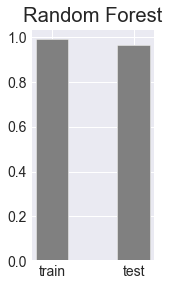

In [81]:
import matplotlib.pyplot as plt
 
# creating the dataset
data = {'train':rf.score(X_train, y_train), 'test':rf.score(X_test, y_test)}
courses = list(data.keys())*10
values = list(data.values())*10
  
fig = plt.figure(figsize = (2, 4))
 
# creating the bar plot
plt.bar(courses, values, color ='Gray',
        width = 0.4)

plt.title("Random Forest")
plt.show()

# Predict & Output

Apply the random forest model on original test dataset, write the prediction of risks (target value) to a .csv file.

In [82]:
# apply the model on test dataset for prediction
id = test.id
result = rf.predict_proba(X_valid)

output = pd.DataFrame( { 'id': id , 'target': result[:,1]} )
output = output[['id', 'target']]

output.to_csv("submission-jiheng-50trees-logic.csv", index = False)
output.head(10)

,id,target
0,0,0.0
1,1,0.0
2,2,0.1
3,3,0.0
4,4,0.1
5,5,0.0
6,6,0.0
7,8,0.0
8,10,0.0
9,11,0.0


# Gaussian Naive Bayes Model

In [83]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
print(nb.score(X_train, y_train) , nb.score(X_test, y_test))

0.7536505635452468 0.7514896619699379


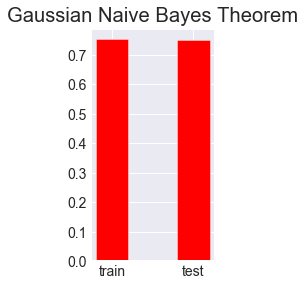

In [85]:
import matplotlib.pyplot as plt
 
# creating the dataset
data = {'train':nb.score(X_train, y_train), 'test':nb.score(X_test, y_test)}
courses = list(data.keys())*10
values = list(data.values())*10
  
fig = plt.figure(figsize = (2, 4))
 
# creating the bar plot
plt.bar(courses, values, color ='red',
        width = 0.4)

plt.title("Gaussian Naive Bayes Theorem")
plt.show()

# Predict & Output

Apply the Naive forest Bayes on original test dataset, write the prediction of risks (target value) to a .csv file.

In [ ]:
# apply the model on test dataset for prediction
id = test.id
result = nb.predict_proba(X_valid)

output = pd.DataFrame( { 'id': id , 'target': result[:,1]} )
output = output[['id', 'target']]

output.to_csv("submission-jiheng-50trees-logic.csv", index = False)
output.head(10)

# GradientBoosting

In [86]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train) , clf.score(X_test, y_test))

0.963307156160596 0.9641193073631863


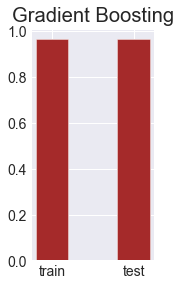

In [88]:
import matplotlib.pyplot as plt
 
# creating the dataset
data = {'train':clf.score(X_train, y_train), 'test':clf.score(X_test, y_test)}
courses = list(data.keys())*10
values = list(data.values())*10
  
fig = plt.figure(figsize = (2, 4))
 
# creating the bar plot
plt.bar(courses, values, color ='brown',
        width = 0.4)

plt.title("Gradient Boosting")
plt.show()

# Predict & Output

In [26]:
# apply the model on test dataset for prediction
id = test.id
result = clf.predict_proba(X_valid)

output = pd.DataFrame( { 'id': id , 'target': result[:,1]} )
output = output[['id', 'target']]

output.to_csv("submission-jiheng-50trees-logic.csv", index = False)
output.head(10)

,id,target
0,0,0.028836
1,1,0.026109
2,2,0.031358
3,3,0.017021
4,4,0.038256
5,5,0.043814
6,6,0.020648
7,8,0.035609
8,10,0.055671
9,11,0.057651
